In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

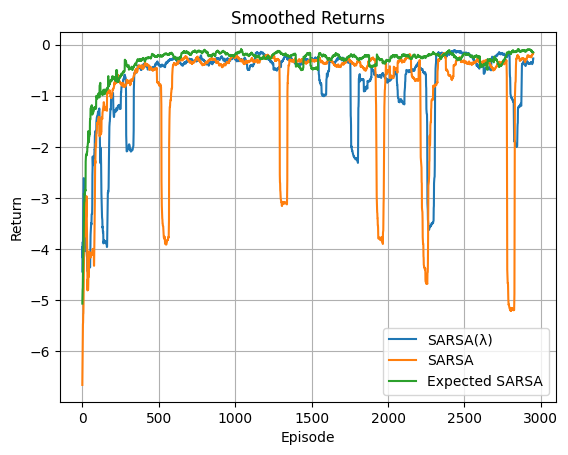

SARSA(λ): avg return (last 100) = -0.346, success rate (last 100) = 1.000
SARSA: avg return (last 100) = -0.224, success rate (last 100) = 1.000
Expected SARSA: avg return (last 100) = -0.135, success rate (last 100) = 1.000


In [14]:
# sarsa_lambda_maze_world_single.py
# One-file implementation: GridWorld env + SARSA(λ) + SARSA + Expected SARSA + runner
# Author: Your Name
# Notes:
# - SARSA(λ) uses replacing traces, ε-decay, and per-episode trace reset.
# - Baselines: SARSA (λ=0) and Expected SARSA for fair comparisons.
# - Environment includes optional slip to test robustness.

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# =========================
# Environment: GridWorld
# =========================

# Actions are encoded as integers for efficiency.
UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]

@dataclass
class GridSpec:
    width: int
    height: int
    start: tuple
    goal: tuple
    walls: set
    pits: set
    step_cost: float = -0.1
    wall_bump_cost: float = -0.3
    pit_cost: float = -10.0
    goal_reward: float = 1.0
    slip_prob: float = 0.0  # with prob p, action slips to a lateral move

class GridWorld:
    """
    Minimal Maze-World (GridWorld):
    - reset(): returns starting state (row, col).
    - step(a): executes action with optional slip; returns (next_state, reward, done, info).
    - Walls block movement (stay in place + wall bump penalty).
    - Goal and pits are terminal.
    """
    def __init__(self, spec: GridSpec, seed: int = 0):
        self.spec = spec
        self.rng = np.random.default_rng(seed)
        self.state = spec.start

    def reset(self):
        self.state = self.spec.start
        return self.state

    def in_bounds(self, x, y):
        return 0 <= x < self.spec.height and 0 <= y < self.spec.width

    def _propose(self, s, a):
        x, y = s
        if a == UP: nx, ny = x - 1, y
        elif a == DOWN: nx, ny = x + 1, y
        elif a == LEFT: nx, ny = x, y - 1
        else: nx, ny = x, y + 1
        return nx, ny

    def _move(self, s, a):
        nx, ny = self._propose(s, a)
        x, y = s
        # Blocked by boundary or wall
        if not self.in_bounds(nx, ny) or (nx, ny) in self.spec.walls:
            return (x, y), self.spec.wall_bump_cost, False
        ns = (nx, ny)
        # Terminal checks
        if ns == self.spec.goal:
            return ns, self.spec.goal_reward, True
        if ns in self.spec.pits:
            return ns, self.spec.pit_cost, True
        # Regular transition
        return ns, self.spec.step_cost, False

    def step(self, a):
        # Slip dynamics: sideways slip with probability p
        if self.spec.slip_prob > 0.0:
            if self.rng.random() < self.spec.slip_prob:
                if a in (UP, DOWN):
                    a = LEFT if self.rng.random() < 0.5 else RIGHT
                else:
                    a = UP if self.rng.random() < 0.5 else DOWN
        ns, r, done = self._move(self.state, a)
        self.state = ns
        return ns, r, done, {}

# =========================
# Policies and utilities
# =========================

def epsilon_greedy(Q, s, epsilon, rng, actions=range(4)):
    """
    ε-greedy action selection over Q(s,·).
    """
    if rng.random() < epsilon:
        return int(rng.choice(list(actions)))
    x, y = s
    return int(np.argmax(Q[x, y]))

def expected_value(Q, s, epsilon, actions=range(4)):
    """
    Expected SARSA target under ε-greedy policy at next state.
    """
    x, y = s
    q = Q[x, y]
    a_star = int(np.argmax(q))
    nA = len(actions)
    pi = np.full(nA, epsilon / nA, dtype=np.float32)
    pi[a_star] += (1.0 - epsilon)
    return float(np.dot(pi, q))

def smooth(x, k=50):
    if len(x) < k:
        return np.array(x)
    return np.convolve(x, np.ones(k)/k, mode='valid')

# =========================
# Algorithms
# =========================

def sarsa_lambda(env, episodes=3000, alpha=0.3, gamma=0.99, lam=0.6,
                 epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997,
                 replacing_traces=True, seed=0):
    """
    Tabular SARSA(λ) with eligibility traces (backward view).
    - Replacing traces recommended in tabular control to avoid trace explosion.
    - Traces reset at each episode start.
    """
    H, W = env.spec.height, env.spec.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)

    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        # Reset traces at episode start, per Sutton & Barto
        e = np.zeros_like(Q, dtype=np.float32)
        s = env.reset()
        eps = max(epsilon_end, epsilon_start * (epsilon_decay ** ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1

            if not done:
                a_next = epsilon_greedy(Q, s_next, eps, rng)
            else:
                a_next = a  # dummy, unused in target when terminal

            # TD error: δ = r + γ Q(s′,a′) − Q(s,a)
            x, y = s
            xp, yp = s_next
            q_sa = Q[x, y, a]
            q_spap = 0.0 if done else Q[xp, yp, a_next]
            delta = r + gamma * q_spap - q_sa

            # Eligibility trace update at current (s,a)
            if replacing_traces:
                e[x, y, a] = 1.0
            else:
                e[x, y, a] += 1.0

            # Vectorized Q update over all (i,j,a): Q += α δ e
            Q += alpha * delta * e

            # Decay traces: e ← γ λ e
            e *= (gamma * lam)

            # Move forward
            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.state == env.spec.goal else 0)

    logs = {
        "returns": np.array(returns),
        "steps": np.array(steps_hist),
        "success": np.array(success),
        "Q": Q
    }
    return Q, logs

def sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
          epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    """
    One-step SARSA (λ=0). On-policy control baseline.
    """
    H, W = env.spec.height, env.spec.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start * (epsilon_decay ** ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if not done:
                a_next = epsilon_greedy(Q, s_next, eps, rng)
                target = r + gamma * Q[s_next[0], s_next[1], a_next]
            else:
                target = r

            Q[s[0], s[1], a] += alpha * (target - Q[s[0], s[1], a])
            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.state == env.spec.goal else 0)

    logs = {
        "returns": np.array(returns),
        "steps": np.array(steps_hist),
        "success": np.array(success),
        "Q": Q
    }
    return Q, logs

def expected_sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
                   epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    """
    Expected SARSA baseline: reduces variance by using E_{a'~π}[Q(s',a')].
    """
    H, W = env.spec.height, env.spec.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start * (epsilon_decay ** ep))
        done, tot, steps = False, 0.0, 0

        while not done:
            a = epsilon_greedy(Q, s, eps, rng)
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if done:
                target = r
            else:
                exp_q = expected_value(Q, s_next, eps)
                target = r + gamma * exp_q

            Q[s[0], s[1], a] += alpha * (target - Q[s[0], s[1], a])
            s = s_next

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.state == env.spec.goal else 0)

    logs = {
        "returns": np.array(returns),
        "steps": np.array(steps_hist),
        "success": np.array(success),
        "Q": Q
    }
    return Q, logs

# =========================
# Runner and plotting
# =========================

def make_env(slip=0.1):
    """
    Define a simple 6x6 maze:
    - Start bottom-left, Goal top-right
    - Some walls and a pit to test penalties
    - Optional slip to stress-test on-policy stability
    """
    walls = {(1,1), (1,2), (2,2), (3,1)}
    pits = {(2,3)}
    spec = GridSpec(
        width=6, height=6,
        start=(5, 0), goal=(0, 5),
        walls=walls, pits=pits,
        step_cost=-0.1, wall_bump_cost=-0.3,
        pit_cost=-10.0, goal_reward=1.0,
        slip_prob=slip
    )
    return GridWorld(spec, seed=123)

def plot_curves(curves, labels, title, ylabel="Return"):
    for y, lbl in zip(curves, labels):
        plt.plot(y, label=lbl)
    plt.legend()
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def main():
    env = make_env(slip=0.1)

    # Train SARSA(λ)
    Ql, logs_l = sarsa_lambda(
        env, episodes=3000, alpha=0.3, gamma=0.99, lam=0.6,
        epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997,
        replacing_traces=True, seed=0
    )

    # Train SARSA
    Qs, logs_s = sarsa(
        env, episodes=3000, alpha=0.3, gamma=0.99,
        epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0
    )

    # Train Expected SARSA
    Qe, logs_e = expected_sarsa(
        env, episodes=3000, alpha=0.3, gamma=0.99,
        epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0
    )

    # Smooth and plot returns
    rL = smooth(logs_l["returns"], k=50)
    rS = smooth(logs_s["returns"], k=50)
    rE = smooth(logs_e["returns"], k=50)
    plot_curves([rL, rS, rE], ["SARSA(λ)", "SARSA", "Expected SARSA"], "Smoothed Returns")

    # Print simple summaries
    for name, logs in [("SARSA(λ)", logs_l), ("SARSA", logs_s), ("Expected SARSA", logs_e)]:
        last100 = logs["returns"][-100:] if len(logs["returns"]) >= 100 else logs["returns"]
        succ100 = logs["success"][-100:] if len(logs["success"]) >= 100 else logs["success"]
        print(f"{name}: avg return (last 100) = {np.mean(last100):.3f}, success rate (last 100) = {np.mean(succ100):.3f}")

if __name__ == "__main__":
    main()


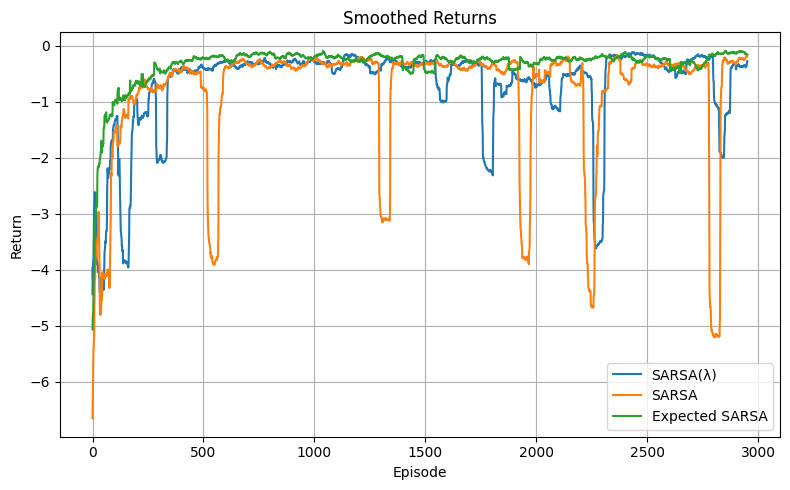

SARSA(λ): avg return (last 100) = -0.346, success rate (last 100) = 1.000
SARSA: avg return (last 100) = -0.224, success rate (last 100) = 1.000
Expected SARSA: avg return (last 100) = -0.135, success rate (last 100) = 1.000


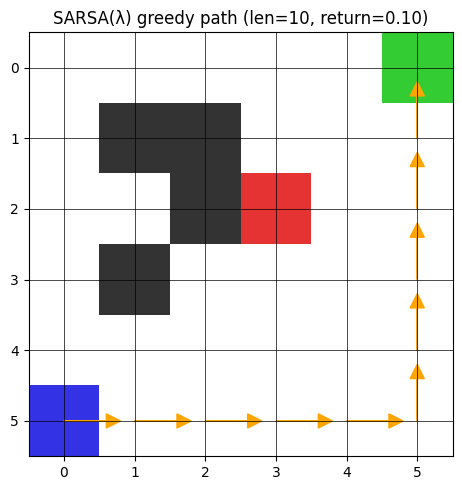

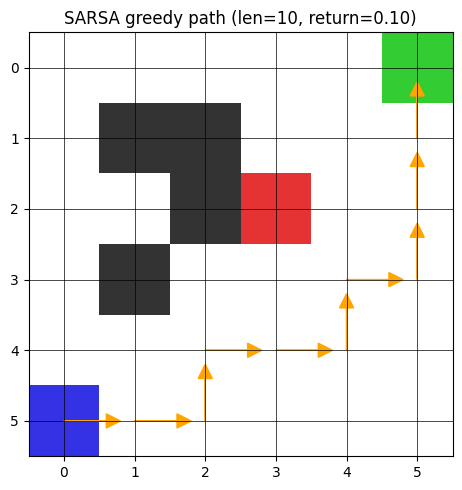

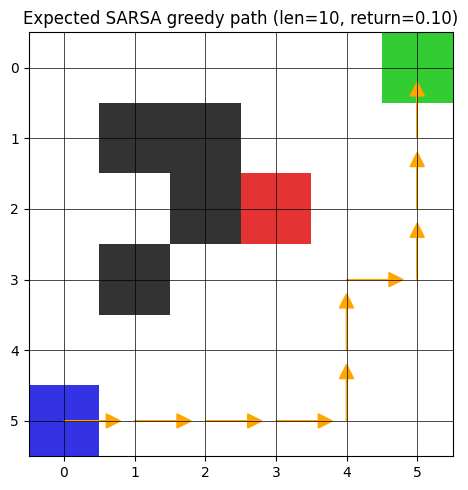

SARSA(λ): avg path length (greedy, slip=0.1) = 12.00, success rate = 1.00
SARSA: avg path length (greedy, slip=0.1) = 12.00, success rate = 1.00
Expected SARSA: avg path length (greedy, slip=0.1) = 10.00, success rate = 1.00


In [15]:

# sarsa_lambda_maze_world_single.py
# One-file implementation: GridWorld env + SARSA(λ) + SARSA + Expected SARSA + runner
# Notes:
# - SARSA(λ) uses replacing traces, ε-decay, and per-episode trace reset.
# - Baselines: SARSA (λ=0) and Expected SARSA for fair comparisons.
# - Environment includes optional slip to test robustness.
# - Added: greedy rollout path plotting and path-length evaluation for comparison.

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# =========================
# Environment: GridWorld
# =========================

UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]

@dataclass
class GridSpec:
    width: int
    height: int
    start: tuple
    goal: tuple
    walls: set
    pits: set
    step_cost: float = -0.1
    wall_bump_cost: float = -0.3
    pit_cost: float = -10.0
    goal_reward: float = 1.0
    slip_prob: float = 0.0  # sideways slip with probability p

class GridWorld:
    def __init__(self, spec: GridSpec, seed: int = 0):
        self.spec = spec
        self.rng = np.random.default_rng(seed)
        self.state = spec.start

    def reset(self):
        self.state = self.spec.start
        return self.state

    def in_bounds(self, x, y):
        return 0 <= x < self.spec.height and 0 <= y < self.spec.width

    def _propose(self, s, a):
        x, y = s
        if a == UP: nx, ny = x - 1, y
        elif a == DOWN: nx, ny = x + 1, y
        elif a == LEFT: nx, ny = x, y - 1
        else: nx, ny = x, y + 1
        return nx, ny

    def _move(self, s, a):
        nx, ny = self._propose(s, a)
        x, y = s
        if not self.in_bounds(nx, ny) or (nx, ny) in self.spec.walls:
            return (x, y), self.spec.wall_bump_cost, False
        ns = (nx, ny)
        if ns == self.spec.goal:
            return ns, self.spec.goal_reward, True
        if ns in self.spec.pits:
            return ns, self.spec.pit_cost, True
        return ns, self.spec.step_cost, False

    def step(self, a):
        if self.spec.slip_prob > 0.0 and self.rng.random() < self.spec.slip_prob:
            if a in (UP, DOWN):
                a = LEFT if self.rng.random() < 0.5 else RIGHT
            else:
                a = UP if self.rng.random() < 0.5 else DOWN
        ns, r, done = self._move(self.state, a)
        self.state = ns
        return ns, r, done, {}

# =========================
# Policies and utilities
# =========================

def epsilon_greedy(Q, s, epsilon, rng, actions=range(4)):
    if rng.random() < epsilon:
        return int(rng.choice(list(actions)))
    x, y = s
    return int(np.argmax(Q[x, y]))

def expected_value(Q, s, epsilon, actions=range(4)):
    x, y = s
    q = Q[x, y]
    a_star = int(np.argmax(q))
    nA = len(actions)
    pi = np.full(nA, epsilon / nA, dtype=np.float32)
    pi[a_star] += (1.0 - epsilon)
    return float(np.dot(pi, q))

def smooth(x, k=50):
    if len(x) < k:
        return np.array(x)
    return np.convolve(x, np.ones(k)/k, mode='valid')

# =========================
# Algorithms
# =========================

def sarsa_lambda(env, episodes=3000, alpha=0.3, gamma=0.99, lam=0.6,
                 epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997,
                 replacing_traces=True, seed=0):
    H, W = env.spec.height, env.spec.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        e = np.zeros_like(Q, dtype=np.float32)  # reset traces each episode
        s = env.reset()
        eps = max(epsilon_end, epsilon_start * (epsilon_decay ** ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if not done:
                a_next = epsilon_greedy(Q, s_next, eps, rng)
            else:
                a_next = a

            x, y = s
            xp, yp = s_next
            q_sa = Q[x, y, a]
            q_spap = 0.0 if done else Q[xp, yp, a_next]
            delta = r + gamma * q_spap - q_sa

            if replacing_traces:
                e[x, y, a] = 1.0
            else:
                e[x, y, a] += 1.0

            Q += alpha * delta * e
            e *= (gamma * lam)

            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.state == env.spec.goal else 0)

    logs = {"returns": np.array(returns), "steps": np.array(steps_hist), "success": np.array(success), "Q": Q}
    return Q, logs

def sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
          epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    H, W = env.spec.height, env.spec.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start * (epsilon_decay ** ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if not done:
                a_next = epsilon_greedy(Q, s_next, eps, rng)
                target = r + gamma * Q[s_next[0], s_next[1], a_next]
            else:
                target = r

            Q[s[0], s[1], a] += alpha * (target - Q[s[0], s[1], a])
            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.state == env.spec.goal else 0)

    logs = {"returns": np.array(returns), "steps": np.array(steps_hist), "success": np.array(success), "Q": Q}
    return Q, logs

def expected_sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
                   epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    H, W = env.spec.height, env.spec.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start * (epsilon_decay ** ep))
        done, tot, steps = False, 0.0, 0

        while not done:
            a = epsilon_greedy(Q, s, eps, rng)
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if done:
                target = r
            else:
                exp_q = expected_value(Q, s_next, eps)
                target = r + gamma * exp_q

            Q[s[0], s[1], a] += alpha * (target - Q[s[0], s[1], a])
            s = s_next

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.state == env.spec.goal else 0)

    logs = {"returns": np.array(returns), "steps": np.array(steps_hist), "success": np.array(success), "Q": Q}
    return Q, logs

# =========================
# Visualization and evaluation
# =========================

def greedy_rollout(env, Q, max_steps=200):
    states = [env.reset()]
    done = False
    steps = 0
    total_reward = 0.0
    while not done and steps < max_steps:
        s = states[-1]
        a = int(np.argmax(Q[s[0], s[1]]))
        s_next, r, done, _ = env.step(a)
        states.append(s_next)
        total_reward += r
        steps += 1
    return states, total_reward, done

def plot_grid_with_path(spec, path, title="Greedy path"):
    H, W = spec.height, spec.width
    grid = np.ones((H, W, 3), dtype=float)  # white
    for (x, y) in spec.walls:
        grid[x, y] = [0.2, 0.2, 0.2]
    for (x, y) in spec.pits:
        grid[x, y] = [0.9, 0.2, 0.2]
    gx, gy = spec.goal
    grid[gx, gy] = [0.2, 0.8, 0.2]
    sx, sy = spec.start
    grid[sx, sy] = [0.2, 0.2, 0.9]

    plt.figure(figsize=(5,5))
    plt.imshow(grid, origin='upper')
    plt.xticks(range(W)); plt.yticks(range(H))
    plt.grid(color='k', linestyle='-', linewidth=0.5)
    for (x0, y0), (x1, y1) in zip(path[:-1], path[1:]):
        plt.arrow(y0, x0, (y1 - y0)*0.8, (x1 - x0)*0.8,
                  head_width=0.2, head_length=0.2, fc='orange', ec='orange', length_includes_head=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def eval_path_length(env_maker, Q, trials=50, slip_for_eval=0.1):
    lengths = []
    successes = 0
    for _ in range(trials):
        env = env_maker(slip=slip_for_eval)
        path, ret, done = greedy_rollout(env, Q)
        if done and env.state == env.spec.goal:
            successes += 1
            lengths.append(len(path)-1)
    avg_len = np.mean(lengths) if lengths else np.inf
    sr = successes / trials
    return avg_len, sr

# =========================
# Runner and plotting
# =========================

def make_env(slip=0.1):
    walls = {(1,1), (1,2), (2,2), (3,1)}
    pits = {(2,3)}
    spec = GridSpec(width=6, height=6,
                    start=(5, 0), goal=(0, 5),
                    walls=walls, pits=pits,
                    step_cost=-0.1, wall_bump_cost=-0.3,
                    pit_cost=-10.0, goal_reward=1.0,
                    slip_prob=slip)
    return GridWorld(spec, seed=123)

def plot_curves(curves, labels, title, ylabel="Return"):
    plt.figure(figsize=(8,5))
    for y, lbl in zip(curves, labels):
        plt.plot(y, label=lbl)
    plt.legend()
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    env = make_env(slip=0.1)

    # Train algorithms
    Ql, logs_l = sarsa_lambda(env, episodes=3000, alpha=0.3, gamma=0.99, lam=0.6,
                              epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997,
                              replacing_traces=True, seed=0)

    Qs, logs_s = sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
                       epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0)

    Qe, logs_e = expected_sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
                                epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0)

    # Smoothed returns
    rL = smooth(logs_l["returns"], k=50)
    rS = smooth(logs_s["returns"], k=50)
    rE = smooth(logs_e["returns"], k=50)
    plot_curves([rL, rS, rE], ["SARSA(λ)", "SARSA", "Expected SARSA"], "Smoothed Returns")

    # Summaries
    for name, logs in [("SARSA(λ)", logs_l), ("SARSA", logs_s), ("Expected SARSA", logs_e)]:
        last100 = logs["returns"][-100:] if len(logs["returns"]) >= 100 else logs["returns"]
        succ100 = logs["success"][-100:] if len(logs["success"]) >= 100 else logs["success"]
        print(f"{name}: avg return (last 100) = {np.mean(last100):.3f}, success rate (last 100) = {np.mean(succ100):.3f}")

    # Path visualizations (use slip=0 for clean arrows)
    for name, Q in [("SARSA(λ)", Ql), ("SARSA", Qs), ("Expected SARSA", Qe)]:
        env_vis = make_env(slip=0.0)
        path, ret, done = greedy_rollout(env_vis, Q)
        title = f"{name} greedy path (len={len(path)-1}, return={ret:.2f})"
        plot_grid_with_path(env_vis.spec, path, title=title)

    # Quantitative path-length comparison under slip
    for name, Q in [("SARSA(λ)", Ql), ("SARSA", Qs), ("Expected SARSA", Qe)]:
        avg_len, sr = eval_path_length(make_env, Q, trials=50, slip_for_eval=0.1)
        print(f"{name}: avg path length (greedy, slip=0.1) = {avg_len:.2f}, success rate = {sr:.2f}")

if __name__ == "__main__":
    main()


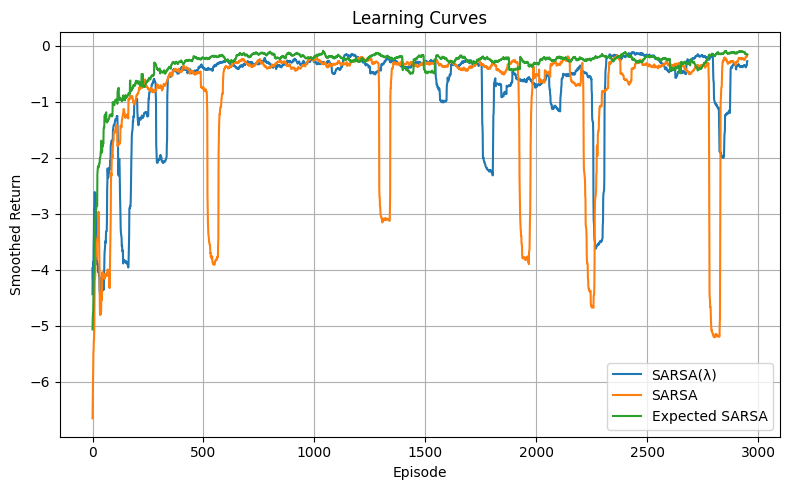

SARSA(λ) greedy rollout length=10, return=0.10


/tmp/ipykernel_37/3264869323.py:254: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  def update(frame): x, y = path[frame]; agent_dot.set_data(y, x); return (agent_dot,)


In [16]:
# sarsa_lambda_maze_world_single.py
# GridWorld + SARSA(λ) + SARSA + Expected SARSA + Animated Visualization

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from dataclasses import dataclass

# =========================
# Environment
# =========================

UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]

@dataclass
class GridSpec:
    width: int
    height: int
    start: tuple
    goal: tuple
    walls: set
    pits: set
    step_cost: float = -0.1
    wall_bump_cost: float = -0.3
    pit_cost: float = -10.0
    goal_reward: float = 1.0
    slip_prob: float = 0.0

class GridWorld:
    def __init__(self, spec: GridSpec, seed: int = 0):
        self.spec = spec
        self.rng = np.random.default_rng(seed)
        self.state = spec.start

    def reset(self):
        self.state = self.spec.start
        return self.state

    def in_bounds(self, x, y):
        return 0 <= x < self.spec.height and 0 <= y < self.spec.width

    def _propose(self, s, a):
        x, y = s
        if a == UP: nx, ny = x - 1, y
        elif a == DOWN: nx, ny = x + 1, y
        elif a == LEFT: nx, ny = x, y - 1
        else: nx, ny = x, y + 1
        return nx, ny

    def _move(self, s, a):
        nx, ny = self._propose(s, a)
        x, y = s
        if not self.in_bounds(nx, ny) or (nx, ny) in self.spec.walls:
            return (x, y), self.spec.wall_bump_cost, False
        ns = (nx, ny)
        if ns == self.spec.goal:
            return ns, self.spec.goal_reward, True
        if ns in self.spec.pits:
            return ns, self.spec.pit_cost, True
        return ns, self.spec.step_cost, False

    def step(self, a):
        # handle slippage
        if self.spec.slip_prob > 0.0 and self.rng.random() < self.spec.slip_prob:
            if a in (UP, DOWN):
                a = LEFT if self.rng.random() < 0.5 else RIGHT
            else:
                a = UP if self.rng.random() < 0.5 else DOWN
        ns, r, done = self._move(self.state, a)
        self.state = ns
        return ns, r, done, {}

# =========================
# Policy helpers
# =========================

def epsilon_greedy(Q, s, epsilon, rng, actions=range(4)):
    if rng.random() < epsilon:
        return int(rng.choice(list(actions)))
    x, y = s
    return int(np.argmax(Q[x, y]))

def expected_value(Q, s, epsilon, actions=range(4)):
    x, y = s
    q = Q[x, y]
    a_star = int(np.argmax(q))
    nA = len(actions)
    pi = np.full(nA, epsilon / nA, dtype=np.float32)
    pi[a_star] += (1.0 - epsilon)
    return float(np.dot(pi, q))

def smooth(x, k=50):
    if len(x) < k:
        return np.array(x)
    return np.convolve(x, np.ones(k)/k, mode='valid')

# =========================
# Algorithms
# =========================

def sarsa_lambda(env, episodes=3000, alpha=0.3, gamma=0.99, lam=0.6,
                 epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997,
                 replacing_traces=True, seed=0):
    H, W = env.spec.height, env.spec.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        e = np.zeros_like(Q, dtype=np.float32)
        s = env.reset()
        eps = max(epsilon_end, epsilon_start * (epsilon_decay ** ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if not done:
                a_next = epsilon_greedy(Q, s_next, eps, rng)
            else:
                a_next = a

            x, y = s
            xp, yp = s_next
            q_sa = Q[x, y, a]
            q_spap = 0.0 if done else Q[xp, yp, a_next]
            delta = r + gamma * q_spap - q_sa

            if replacing_traces:
                e[x, y, a] = 1.0
            else:
                e[x, y, a] += 1.0

            Q += alpha * delta * e
            e *= (gamma * lam)

            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.state == env.spec.goal else 0)

    logs = {"returns": np.array(returns), "steps": np.array(steps_hist), "success": np.array(success), "Q": Q}
    return Q, logs

def sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
          epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    H, W = env.spec.height, env.spec.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start * (epsilon_decay ** ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if not done:
                a_next = epsilon_greedy(Q, s_next, eps, rng)
                target = r + gamma * Q[s_next[0], s_next[1], a_next]
            else:
                target = r

            Q[s[0], s[1], a] += alpha * (target - Q[s[0], s[1], a])
            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.state == env.spec.goal else 0)

    logs = {"returns": np.array(returns), "steps": np.array(steps_hist), "success": np.array(success), "Q": Q}
    return Q, logs

def expected_sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
                   epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    H, W = env.spec.height, env.spec.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start * (epsilon_decay ** ep))
        done, tot, steps = False, 0.0, 0

        while not done:
            a = epsilon_greedy(Q, s, eps, rng)
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if done:
                target = r
            else:
                exp_q = expected_value(Q, s_next, eps)
                target = r + gamma * exp_q

            Q[s[0], s[1], a] += alpha * (target - Q[s[0], s[1], a])
            s = s_next

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.state == env.spec.goal else 0)

    logs = {"returns": np.array(returns), "steps": np.array(steps_hist), "success": np.array(success), "Q": Q}
    return Q, logs

# =========================
# Visualization and animation
# =========================

def greedy_rollout(env, Q, max_steps=200):
    states = [env.reset()]
    done = False
    steps = 0
    total_reward = 0.0
    while not done and steps < max_steps:
        s = states[-1]
        a = int(np.argmax(Q[s[0], s[1]]))
        s_next, r, done, _ = env.step(a)
        states.append(s_next)
        total_reward += r
        steps += 1
    return states, total_reward, done

def animate_path(spec, path, title="Animated Agent Movement", interval=400):
    H, W = spec.height, spec.width
    grid = np.ones((H, W, 3), dtype=float)

    for (x, y) in spec.walls: grid[x, y] = [0.2, 0.2, 0.2]
    for (x, y) in spec.pits: grid[x, y] = [0.9, 0.2, 0.2]
    gx, gy = spec.goal; grid[gx, gy] = [0.2, 0.8, 0.2]
    sx, sy = spec.start; grid[sx, sy] = [0.2, 0.2, 0.9]

    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(grid, origin='upper')
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.grid(color='k', linestyle='-', linewidth=0.5)
    ax.set_title(title)
    agent_dot, = ax.plot([], [], 'o', color='orange', markersize=12)

    def init(): agent_dot.set_data([], []); return (agent_dot,)
    def update(frame): x, y = path[frame]; agent_dot.set_data(y, x); return (agent_dot,)

    ani = animation.FuncAnimation(fig, update, frames=len(path), init_func=init, blit=True,
                                  repeat=False, interval=interval)
    plt.close(fig)
    return HTML(ani.to_jshtml())

# =========================
# Evaluation + Runner
# =========================

def make_env(slip=0.1):
    walls = {(1,1), (1,2), (2,2), (3,1)}
    pits = {(2,3)}
    spec = GridSpec(width=6, height=6,
                    start=(5, 0), goal=(0, 5),
                    walls=walls, pits=pits,
                    step_cost=-0.1, wall_bump_cost=-0.3,
                    pit_cost=-10.0, goal_reward=1.0,
                    slip_prob=slip)
    return GridWorld(spec, seed=123)

def smooth_plot_curves(curves, labels, title):
    plt.figure(figsize=(8,5))
    for y, lbl in zip(curves, labels):
        plt.plot(smooth(y), label=lbl)
    plt.legend(); plt.title(title)
    plt.xlabel("Episode"); plt.ylabel("Smoothed Return")
    plt.grid(True); plt.tight_layout()
    plt.show()

def main():
    env = make_env(slip=0.1)
    Ql, logs_l = sarsa_lambda(env)
    Qs, logs_s = sarsa(env)
    Qe, logs_e = expected_sarsa(env)

    smooth_plot_curves([logs_l["returns"], logs_s["returns"], logs_e["returns"]],
                       ["SARSA(λ)", "SARSA", "Expected SARSA"],
                       "Learning Curves")

    # Animated rollout for SARSA(λ)
    env_anim = make_env(slip=0.0)
    path, ret, done = greedy_rollout(env_anim, Ql)
    print(f"SARSA(λ) greedy rollout length={len(path)-1}, return={ret:.2f}")
    display(animate_path(env_anim.spec, path, title="SARSA(λ) Animated Rollout"))

if __name__ == "__main__":
    main()


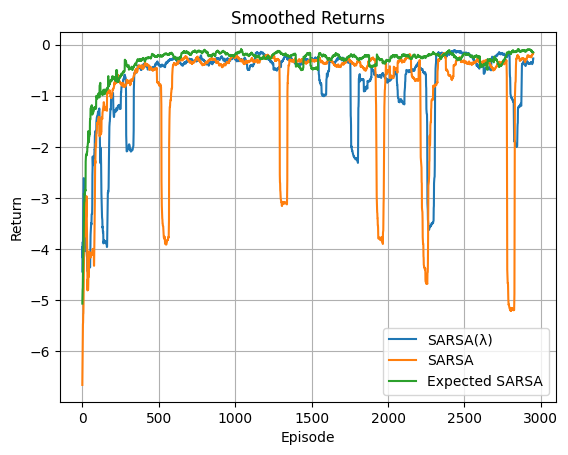

SARSA(λ): avg return (last 100) = -0.346, success rate (last 100) = 1.000
SARSA: avg return (last 100) = -0.224, success rate (last 100) = 1.000
Expected SARSA: avg return (last 100) = -0.135, success rate (last 100) = 1.000


In [20]:
# sarsa_lambda_maxworld.py
# One-file implementation: MaxWorld env + SARSA(λ) + SARSA + Expected SARSA + runner

import numpy as np
import matplotlib.pyplot as plt

# =========================
# Environment: MaxWorld
# =========================

UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]

class MaxWorld:
    def __init__(self, height=6, width=6, slip_prob=0.1):
        self.height = height
        self.width = width
        self.n_actions = 4
        self.slip_prob = slip_prob
        self.start = (5, 0)
        self.goal = (0, 5)
        self.walls = {(1,1),(1,2),(2,2),(3,1)}
        self.pits = {(2,3)}
        self.step_cost = -0.1
        self.wall_bump_cost = -0.3
        self.pit_cost = -10.0
        self.goal_reward = 1.0
        self.state = self.start
        self.rng = np.random.default_rng(123)

    def reset(self):
        self.state = self.start
        return self.state

    def in_bounds(self, x, y):
        return 0 <= x < self.height and 0 <= y < self.width

    def _propose(self, s, a):
        x, y = s
        if a == UP: nx, ny = x-1, y
        elif a == DOWN: nx, ny = x+1, y
        elif a == LEFT: nx, ny = x, y-1
        else: nx, ny = x, y+1
        return nx, ny

    def step(self, a):
        # Slip
        if self.slip_prob>0 and self.rng.random() < self.slip_prob:
            if a in (UP, DOWN):
                a = LEFT if self.rng.random()<0.5 else RIGHT
            else:
                a = UP if self.rng.random()<0.5 else DOWN
        nx, ny = self._propose(self.state, a)
        x, y = self.state
        if not self.in_bounds(nx, ny) or (nx, ny) in self.walls:
            next_state = (x, y)
            reward = self.wall_bump_cost
            done = False
        elif (nx, ny) == self.goal:
            next_state = (nx, ny)
            reward = self.goal_reward
            done = True
        elif (nx, ny) in self.pits:
            next_state = (nx, ny)
            reward = self.pit_cost
            done = True
        else:
            next_state = (nx, ny)
            reward = self.step_cost
            done = False
        self.state = next_state
        return next_state, reward, done, {}

    def is_goal(self, s):
        return s == self.goal

# =========================
# Policies and utilities
# =========================

def epsilon_greedy(Q, s, epsilon, rng, actions=range(4)):
    if rng.random() < epsilon:
        return int(rng.choice(list(actions)))
    x, y = s
    return int(np.argmax(Q[x, y]))

def expected_value(Q, s, epsilon, actions=range(4)):
    x, y = s
    q = Q[x, y]
    a_star = int(np.argmax(q))
    nA = len(actions)
    pi = np.full(nA, epsilon/nA, dtype=np.float32)
    pi[a_star] += (1.0 - epsilon)
    return float(np.dot(pi, q))

def smooth(x, k=50):
    if len(x) < k: return np.array(x)
    return np.convolve(x, np.ones(k)/k, mode='valid')

# =========================
# Algorithms
# =========================

def sarsa_lambda(env, episodes=3000, alpha=0.3, gamma=0.99, lam=0.6,
                 epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997,
                 replacing_traces=True, seed=0):
    H, W = env.height, env.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        e = np.zeros_like(Q, dtype=np.float32)
        s = env.reset()
        eps = max(epsilon_end, epsilon_start*(epsilon_decay**ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            a_next = epsilon_greedy(Q, s_next, eps, rng) if not done else a
            delta = r + (0 if done else gamma*Q[s_next[0], s_next[1], a_next]) - Q[s[0], s[1], a]
            e[s[0], s[1], a] = 1.0 if replacing_traces else e[s[0], s[1], a]+1.0
            Q += alpha * delta * e
            e *= gamma*lam
            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.is_goal(env.state) else 0)

    return Q, {"returns":np.array(returns), "steps":np.array(steps_hist), "success":np.array(success), "Q":Q}

def sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
          epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    H, W = env.height, env.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start*(epsilon_decay**ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if not done:
                a_next = epsilon_greedy(Q, s_next, eps, rng)
                target = r + gamma*Q[s_next[0], s_next[1], a_next]
            else:
                target = r
            Q[s[0], s[1], a] += alpha*(target - Q[s[0], s[1], a])
            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.is_goal(env.state) else 0)

    return Q, {"returns":np.array(returns), "steps":np.array(steps_hist), "success":np.array(success), "Q":Q}

def expected_sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
                   epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    H, W = env.height, env.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start*(epsilon_decay**ep))
        done, tot, steps = False, 0.0, 0

        while not done:
            a = epsilon_greedy(Q, s, eps, rng)
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if done:
                target = r
            else:
                target = r + gamma*expected_value(Q, s_next, eps)
            Q[s[0], s[1], a] += alpha*(target - Q[s[0], s[1], a])
            s = s_next

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.is_goal(env.state) else 0)

    return Q, {"returns":np.array(returns), "steps":np.array(steps_hist), "success":np.array(success), "Q":Q}

# =========================
# Runner and plotting
# =========================

def plot_curves(curves, labels, title, ylabel="Return"):
    for y, lbl in zip(curves, labels):
        plt.plot(y, label=lbl)
    plt.legend()
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def main():
    env = MaxWorld(slip_prob=0.1)

    Ql, logs_l = sarsa_lambda(env)
    Qs, logs_s = sarsa(env)
    Qe, logs_e = expected_sarsa(env)

    rL = smooth(logs_l["returns"])
    rS = smooth(logs_s["returns"])
    rE = smooth(logs_e["returns"])
    plot_curves([rL, rS, rE], ["SARSA(λ)", "SARSA", "Expected SARSA"], "Smoothed Returns")

    for name, logs in [("SARSA(λ)", logs_l), ("SARSA", logs_s), ("Expected SARSA", logs_e)]:
        last100 = logs["returns"][-100:]
        succ100 = logs["success"][-100:]
        print(f"{name}: avg return (last 100) = {np.mean(last100):.3f}, success rate (last 100) = {np.mean(succ100):.3f}")

if __name__ == "__main__":
    main()


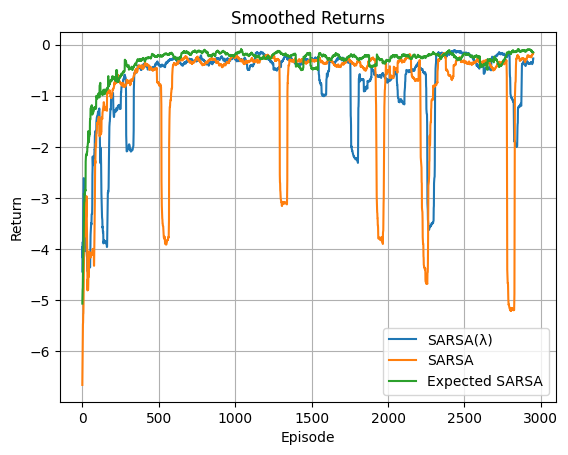

SARSA(λ): avg return (last 100)=-0.346, success rate=1.000
SARSA: avg return (last 100)=-0.224, success rate=1.000
Expected SARSA: avg return (last 100)=-0.135, success rate=1.000
SARSA(λ) greedy rollout length=10, return=0.10


/tmp/ipykernel_37/1708779521.py:233: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  def update(frame): x,y=path[frame]; agent_dot.set_data(y,x); return (agent_dot,)


In [23]:
# sarsa_lambda_maxworld_animated.py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

# =========================
# MaxWorld Environment
# =========================

UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]

class MaxWorld:
    def __init__(self, height=6, width=6, slip_prob=0.1):
        self.height = height
        self.width = width
        self.n_actions = 4
        self.slip_prob = slip_prob
        self.start = (5, 0)
        self.goal = (0, 5)
        self.walls = {(1,1),(1,2),(2,2),(3,1)}
        self.pits = {(2,3)}
        self.step_cost = -0.1
        self.wall_bump_cost = -0.3
        self.pit_cost = -10.0
        self.goal_reward = 1.0
        self.state = self.start
        self.rng = np.random.default_rng(123)

    def reset(self):
        self.state = self.start
        return self.state

    def in_bounds(self, x, y):
        return 0 <= x < self.height and 0 <= y < self.width

    def _propose(self, s, a):
        x, y = s
        if a == UP: nx, ny = x-1, y
        elif a == DOWN: nx, ny = x+1, y
        elif a == LEFT: nx, ny = x, y-1
        else: nx, ny = x, y+1
        return nx, ny

    def step(self, a):
        if self.slip_prob>0 and self.rng.random() < self.slip_prob:
            if a in (UP, DOWN):
                a = LEFT if self.rng.random()<0.5 else RIGHT
            else:
                a = UP if self.rng.random()<0.5 else DOWN
        nx, ny = self._propose(self.state, a)
        x, y = self.state
        if not self.in_bounds(nx, ny) or (nx, ny) in self.walls:
            next_state = (x, y)
            reward = self.wall_bump_cost
            done = False
        elif (nx, ny) == self.goal:
            next_state = (nx, ny)
            reward = self.goal_reward
            done = True
        elif (nx, ny) in self.pits:
            next_state = (nx, ny)
            reward = self.pit_cost
            done = True
        else:
            next_state = (nx, ny)
            reward = self.step_cost
            done = False
        self.state = next_state
        return next_state, reward, done, {}

    def is_goal(self, s):
        return s == self.goal

# =========================
# Policies & utilities
# =========================

def epsilon_greedy(Q, s, epsilon, rng, actions=range(4)):
    if rng.random() < epsilon:
        return int(rng.choice(list(actions)))
    x, y = s
    return int(np.argmax(Q[x, y]))

def expected_value(Q, s, epsilon, actions=range(4)):
    x, y = s
    q = Q[x, y]
    a_star = int(np.argmax(q))
    nA = len(actions)
    pi = np.full(nA, epsilon/nA, dtype=np.float32)
    pi[a_star] += (1.0 - epsilon)
    return float(np.dot(pi, q))

def smooth(x, k=50):
    if len(x) < k: return np.array(x)
    return np.convolve(x, np.ones(k)/k, mode='valid')

# =========================
# SARSA algorithms
# =========================

def sarsa_lambda(env, episodes=3000, alpha=0.3, gamma=0.99, lam=0.6,
                 epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997,
                 replacing_traces=True, seed=0):
    H, W = env.height, env.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        e = np.zeros_like(Q, dtype=np.float32)
        s = env.reset()
        eps = max(epsilon_end, epsilon_start*(epsilon_decay**ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            a_next = epsilon_greedy(Q, s_next, eps, rng) if not done else a
            delta = r + (0 if done else gamma*Q[s_next[0], s_next[1], a_next]) - Q[s[0], s[1], a]
            e[s[0], s[1], a] = 1.0 if replacing_traces else e[s[0], s[1], a]+1.0
            Q += alpha * delta * e
            e *= gamma*lam
            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.is_goal(env.state) else 0)

    return Q, {"returns":np.array(returns), "steps":np.array(steps_hist), "success":np.array(success), "Q":Q}

def sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
          epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    H, W = env.height, env.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start*(epsilon_decay**ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if not done:
                a_next = epsilon_greedy(Q, s_next, eps, rng)
                target = r + gamma*Q[s_next[0], s_next[1], a_next]
            else:
                target = r
            Q[s[0], s[1], a] += alpha*(target - Q[s[0], s[1], a])
            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.is_goal(env.state) else 0)

    return Q, {"returns":np.array(returns), "steps":np.array(steps_hist), "success":np.array(success), "Q":Q}

def expected_sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
                   epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    H, W = env.height, env.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start*(epsilon_decay**ep))
        done, tot, steps = False, 0.0, 0

        while not done:
            a = epsilon_greedy(Q, s, eps, rng)
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if done:
                target = r
            else:
                target = r + gamma*expected_value(Q, s_next, eps)
            Q[s[0], s[1], a] += alpha*(target - Q[s[0], s[1], a])
            s = s_next

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.is_goal(env.state) else 0)

    return Q, {"returns":np.array(returns), "steps":np.array(steps_hist), "success":np.array(success), "Q":Q}

# =========================
# Rollout animation
# =========================

def greedy_rollout(env, Q, max_steps=200):
    states = [env.reset()]
    total_reward = 0.0
    done = False
    steps = 0
    while not done and steps<max_steps:
        s = states[-1]
        a = int(np.argmax(Q[s[0], s[1]]))
        s_next, r, done, _ = env.step(a)
        states.append(s_next)
        total_reward += r
        steps += 1
    return states, total_reward, done

def animate_path(env, path, interval=400, title="Agent Rollout"):
    H, W = env.height, env.width
    grid = np.ones((H,W,3), dtype=float)
    for (x,y) in env.walls: grid[x,y]=[0.2,0.2,0.2]
    for (x,y) in env.pits: grid[x,y]=[0.9,0.2,0.2]
    gx,gy = env.goal; grid[gx,gy]=[0.2,0.8,0.2]
    sx,sy = env.start; grid[sx,sy]=[0.2,0.2,0.9]

    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(grid, origin='upper')
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.grid(color='k', linestyle='-', linewidth=0.5)
    ax.set_title(title)
    agent_dot, = ax.plot([], [], 'o', color='orange', markersize=12)

    def init(): agent_dot.set_data([],[]); return (agent_dot,)
    def update(frame): x,y=path[frame]; agent_dot.set_data(y,x); return (agent_dot,)

    ani = animation.FuncAnimation(fig, update, frames=len(path), init_func=init,
                                  blit=True, repeat=False, interval=interval)
    plt.close(fig)
    return HTML(ani.to_jshtml())

# =========================
# Runner and plotting
# =========================

def plot_curves(curves, labels, title, ylabel="Return"):
    for y,lbl in zip(curves,labels): plt.plot(y,label=lbl)
    plt.legend(); plt.title(title); plt.xlabel("Episode"); plt.ylabel(ylabel)
    plt.grid(True); plt.show()

def main():
    env = MaxWorld(slip_prob=0.1)

    # Train algorithms
    Ql, logs_l = sarsa_lambda(env)
    Qs, logs_s = sarsa(env)
    Qe, logs_e = expected_sarsa(env)

    # Smooth returns
    rL = smooth(logs_l["returns"])
    rS = smooth(logs_s["returns"])
    rE = smooth(logs_e["returns"])
    plot_curves([rL,rS,rE], ["SARSA(λ)","SARSA","Expected SARSA"], "Smoothed Returns")

    # Print summaries
    for name, logs in [("SARSA(λ)",logs_l),("SARSA",logs_s),("Expected SARSA",logs_e)]:
        last100 = logs["returns"][-100:]
        succ100 = logs["success"][-100:]
        print(f"{name}: avg return (last 100)={np.mean(last100):.3f}, success rate={np.mean(succ100):.3f}")

    # Animated rollout using SARSA(λ)
    env_anim = MaxWorld(slip_prob=0.0)
    path, ret, done = greedy_rollout(env_anim, Ql)
    print(f"SARSA(λ) greedy rollout length={len(path)-1}, return={ret:.2f}")
    display(animate_path(env_anim, path, title="SARSA(λ) Greedy Rollout"))

if __name__=="__main__":
    main()


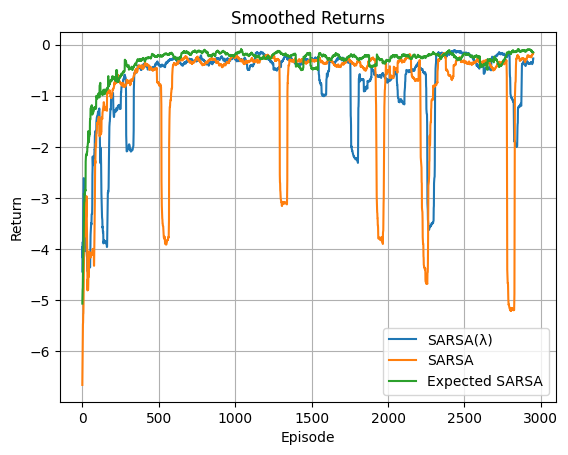

SARSA(λ): avg return (last 100)=-0.346, success rate=1.000
SARSA: avg return (last 100)=-0.224, success rate=1.000
Expected SARSA: avg return (last 100)=-0.135, success rate=1.000
SARSA(λ) greedy rollout length=10, return=0.10


/tmp/ipykernel_37/4085197904.py:233: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  def update(frame): x,y=path[frame]; agent_dot.set_data(y,x); return (agent_dot,)


SARSA greedy rollout length=10, return=0.10


/tmp/ipykernel_37/4085197904.py:233: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  def update(frame): x,y=path[frame]; agent_dot.set_data(y,x); return (agent_dot,)


Expected SARSA greedy rollout length=10, return=0.10


/tmp/ipykernel_37/4085197904.py:233: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  def update(frame): x,y=path[frame]; agent_dot.set_data(y,x); return (agent_dot,)


In [24]:
# sarsa_lambda_maxworld_animated.py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

# =========================
# MaxWorld Environment
# =========================

UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
ACTIONS = [UP, DOWN, LEFT, RIGHT]

class MaxWorld:
    def __init__(self, height=6, width=6, slip_prob=0.1):
        self.height = height
        self.width = width
        self.n_actions = 4
        self.slip_prob = slip_prob
        self.start = (5, 0)
        self.goal = (0, 5)
        self.walls = {(1,1),(1,2),(2,2),(3,1)}
        self.pits = {(2,3)}
        self.step_cost = -0.1
        self.wall_bump_cost = -0.3
        self.pit_cost = -10.0
        self.goal_reward = 1.0
        self.state = self.start
        self.rng = np.random.default_rng(123)

    def reset(self):
        self.state = self.start
        return self.state

    def in_bounds(self, x, y):
        return 0 <= x < self.height and 0 <= y < self.width

    def _propose(self, s, a):
        x, y = s
        if a == UP: nx, ny = x-1, y
        elif a == DOWN: nx, ny = x+1, y
        elif a == LEFT: nx, ny = x, y-1
        else: nx, ny = x, y+1
        return nx, ny

    def step(self, a):
        if self.slip_prob>0 and self.rng.random() < self.slip_prob:
            if a in (UP, DOWN):
                a = LEFT if self.rng.random()<0.5 else RIGHT
            else:
                a = UP if self.rng.random()<0.5 else DOWN
        nx, ny = self._propose(self.state, a)
        x, y = self.state
        if not self.in_bounds(nx, ny) or (nx, ny) in self.walls:
            next_state = (x, y)
            reward = self.wall_bump_cost
            done = False
        elif (nx, ny) == self.goal:
            next_state = (nx, ny)
            reward = self.goal_reward
            done = True
        elif (nx, ny) in self.pits:
            next_state = (nx, ny)
            reward = self.pit_cost
            done = True
        else:
            next_state = (nx, ny)
            reward = self.step_cost
            done = False
        self.state = next_state
        return next_state, reward, done, {}

    def is_goal(self, s):
        return s == self.goal

# =========================
# Policies & utilities
# =========================

def epsilon_greedy(Q, s, epsilon, rng, actions=range(4)):
    if rng.random() < epsilon:
        return int(rng.choice(list(actions)))
    x, y = s
    return int(np.argmax(Q[x, y]))

def expected_value(Q, s, epsilon, actions=range(4)):
    x, y = s
    q = Q[x, y]
    a_star = int(np.argmax(q))
    nA = len(actions)
    pi = np.full(nA, epsilon/nA, dtype=np.float32)
    pi[a_star] += (1.0 - epsilon)
    return float(np.dot(pi, q))

def smooth(x, k=50):
    if len(x) < k: return np.array(x)
    return np.convolve(x, np.ones(k)/k, mode='valid')

# =========================
# SARSA algorithms
# =========================

def sarsa_lambda(env, episodes=3000, alpha=0.3, gamma=0.99, lam=0.6,
                 epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997,
                 replacing_traces=True, seed=0):
    H, W = env.height, env.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        e = np.zeros_like(Q, dtype=np.float32)
        s = env.reset()
        eps = max(epsilon_end, epsilon_start*(epsilon_decay**ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            a_next = epsilon_greedy(Q, s_next, eps, rng) if not done else a
            delta = r + (0 if done else gamma*Q[s_next[0], s_next[1], a_next]) - Q[s[0], s[1], a]
            e[s[0], s[1], a] = 1.0 if replacing_traces else e[s[0], s[1], a]+1.0
            Q += alpha * delta * e
            e *= gamma*lam
            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.is_goal(env.state) else 0)

    return Q, {"returns":np.array(returns), "steps":np.array(steps_hist), "success":np.array(success), "Q":Q}

def sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
          epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    H, W = env.height, env.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start*(epsilon_decay**ep))
        a = epsilon_greedy(Q, s, eps, rng)
        done, tot, steps = False, 0.0, 0

        while not done:
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if not done:
                a_next = epsilon_greedy(Q, s_next, eps, rng)
                target = r + gamma*Q[s_next[0], s_next[1], a_next]
            else:
                target = r
            Q[s[0], s[1], a] += alpha*(target - Q[s[0], s[1], a])
            s, a = s_next, (a_next if not done else a)

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.is_goal(env.state) else 0)

    return Q, {"returns":np.array(returns), "steps":np.array(steps_hist), "success":np.array(success), "Q":Q}

def expected_sarsa(env, episodes=3000, alpha=0.3, gamma=0.99,
                   epsilon_start=0.4, epsilon_end=0.05, epsilon_decay=0.997, seed=0):
    H, W = env.height, env.width
    nA = 4
    rng = np.random.default_rng(seed)
    Q = np.zeros((H, W, nA), dtype=np.float32)
    returns, steps_hist, success = [], [], []

    for ep in range(episodes):
        s = env.reset()
        eps = max(epsilon_end, epsilon_start*(epsilon_decay**ep))
        done, tot, steps = False, 0.0, 0

        while not done:
            a = epsilon_greedy(Q, s, eps, rng)
            s_next, r, done, _ = env.step(a)
            tot += r
            steps += 1
            if done:
                target = r
            else:
                target = r + gamma*expected_value(Q, s_next, eps)
            Q[s[0], s[1], a] += alpha*(target - Q[s[0], s[1], a])
            s = s_next

        returns.append(tot)
        steps_hist.append(steps)
        success.append(1 if env.is_goal(env.state) else 0)

    return Q, {"returns":np.array(returns), "steps":np.array(steps_hist), "success":np.array(success), "Q":Q}

# =========================
# Rollout animation
# =========================

def greedy_rollout(env, Q, max_steps=200):
    states = [env.reset()]
    total_reward = 0.0
    done = False
    steps = 0
    while not done and steps<max_steps:
        s = states[-1]
        a = int(np.argmax(Q[s[0], s[1]]))
        s_next, r, done, _ = env.step(a)
        states.append(s_next)
        total_reward += r
        steps += 1
    return states, total_reward, done

def animate_path(env, path, interval=400, title="Agent Rollout"):
    H, W = env.height, env.width
    grid = np.ones((H,W,3), dtype=float)
    for (x,y) in env.walls: grid[x,y]=[0.2,0.2,0.2]
    for (x,y) in env.pits: grid[x,y]=[0.9,0.2,0.2]
    gx,gy = env.goal; grid[gx,gy]=[0.2,0.8,0.2]
    sx,sy = env.start; grid[sx,sy]=[0.2,0.2,0.9]

    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(grid, origin='upper')
    ax.set_xticks(range(W)); ax.set_yticks(range(H))
    ax.grid(color='k', linestyle='-', linewidth=0.5)
    ax.set_title(title)
    agent_dot, = ax.plot([], [], 'o', color='orange', markersize=12)

    def init(): agent_dot.set_data([],[]); return (agent_dot,)
    def update(frame): x,y=path[frame]; agent_dot.set_data(y,x); return (agent_dot,)

    ani = animation.FuncAnimation(fig, update, frames=len(path), init_func=init,
                                  blit=True, repeat=False, interval=interval)
    plt.close(fig)
    return HTML(ani.to_jshtml())

# =========================
# Runner and plotting
# =========================

def plot_curves(curves, labels, title, ylabel="Return"):
    for y,lbl in zip(curves,labels): plt.plot(y,label=lbl)
    plt.legend(); plt.title(title); plt.xlabel("Episode"); plt.ylabel(ylabel)
    plt.grid(True); plt.show()

def main():
    env = MaxWorld(slip_prob=0.1)

    # Train algorithms
    Ql, logs_l = sarsa_lambda(env)
    Qs, logs_s = sarsa(env)
    Qe, logs_e = expected_sarsa(env)

    # Smooth returns
    rL = smooth(logs_l["returns"])
    rS = smooth(logs_s["returns"])
    rE = smooth(logs_e["returns"])
    plot_curves([rL,rS,rE], ["SARSA(λ)","SARSA","Expected SARSA"], "Smoothed Returns")

    # Print summaries
    for name, logs in [("SARSA(λ)",logs_l),("SARSA",logs_s),("Expected SARSA",logs_e)]:
        last100 = logs["returns"][-100:]
        succ100 = logs["success"][-100:]
        print(f"{name}: avg return (last 100)={np.mean(last100):.3f}, success rate={np.mean(succ100):.3f}")

    # Animated rollout using SARSA(λ)
    env_anim = MaxWorld(slip_prob=0.0)
    path_l, ret_l, done_l = greedy_rollout(env_anim, Ql)
    print(f"SARSA(λ) greedy rollout length={len(path_l)-1}, return={ret_l:.2f}")
    display(animate_path(env_anim, path_l, title="SARSA(λ) Greedy Rollout"))

    # Animated rollout using SARSA
    env_anim = MaxWorld(slip_prob=0.0)
    path_s, ret_s, done_s = greedy_rollout(env_anim, Qs)
    print(f"SARSA greedy rollout length={len(path_s)-1}, return={ret_s:.2f}")
    display(animate_path(env_anim, path_s, title="SARSA Greedy Rollout"))

    # Animated rollout using Expected SARSA
    env_anim = MaxWorld(slip_prob=0.0)
    path_e, ret_e, done_e = greedy_rollout(env_anim, Qe)
    print(f"Expected SARSA greedy rollout length={len(path_e)-1}, return={ret_e:.2f}")
    display(animate_path(env_anim, path_e, title="Expected SARSA Greedy Rollout"))

if __name__=="__main__":
    main()
